# Predict low high models
Model selection for predict lo hi


To install conda and binance packages to this notebook uncomment the code below

In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
#%pip install binance-connector==1.13.0
%pip install pandas
%pip install scikit-learn
%pip install tensorflow==2.11.0
%pip install keras==2.11.0
%pip install scikeras
%pip install keras-tuner

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

### Read data from bot's history

In [3]:
import os
import glob
import pandas as pd
from datetime import timedelta,date

def read_last_data(strategy, days=1, n=None):
    """ Read last last day from bot history """
    
    def read_last(symbol: str, name: str, days=1):
        data_dir=f"./../data/yandex-cloud/{strategy}/Xy"
        file_paths = sorted([f"{data_dir}/{f}" for f in os.listdir(data_dir) if f.endswith(f"{symbol}_{name}.csv")])[-days:]
        print(file_paths)
        return pd.concat([pd.read_csv(f, parse_dates=True, index_col="datetime") for f in file_paths])

    data=read_last("BTCUSDT", "data", days)
    X=read_last("BTCUSDT", "X", days)
    y=read_last("BTCUSDT", "y", days)
    if n: 
        data=data.tail(n)
        X=X.tail(n)
        y=y.tail(n)
    return data,X,y

#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy"
bidask,X_bot,y_bot = read_last_data(strategy, days=1, n=100000)

['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-24_BTCUSDT_data.csv']
['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-24_BTCUSDT_X.csv']
['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-24_BTCUSDT_y.csv']


### Resample data to use equal time intervals

In [4]:
import re
def get_targets(bidask, predict_window="10s"):
    """ 
    Calculate targets - bid/ask bounds in future prediction window
    """
    fut_min=bidask[["bid", "ask"]][::-1].rolling(predict_window).min()[::-1].rename(columns={"bid":"bid_min_fut", "ask":"ask_min_fut"})
    fut_max=bidask[["bid", "ask"]][::-1].rolling(predict_window).max()[::-1].rename(columns={"bid":"bid_max_fut", "ask":"ask_max_fut"})
    return pd.concat([fut_min, fut_max], axis = 1)
    
def resampled(X: pd.DataFrame, y: pd.DataFrame, time_interval) -> (pd.DataFrame, pd.DataFrame):
    """ Resample to make equal intervals time series """
    if int(re.sub(r'\D', "", time_interval)) == 0:
        return X, y
    Xy=pd.concat([X,y], axis=1)
    diffmap = [(c, "sum") for c in Xy.columns if c.endswith("diff")]
    timemap = [(c, "last") for c in Xy.columns if c.startswith("time") and not c.endswith("diff")]
    l2map = [(c, "last") for c in Xy.columns if c.startswith("l2_")]
    
    futmap = [(c, "last") for c in Xy.columns if c.endswith("_fut")]
    colmap = dict(diffmap + timemap + l2map + futmap + [("spread", "last")])
    resampled = Xy.resample(time_interval).agg(colmap).dropna()
    return resampled[X.columns], resampled[y.columns]

predict_window="10s"
resample_interval="0s"
y_raw = get_targets(bidask, predict_window)
#X,y = resampled(X_bot, y_raw, resample_interval)
X,y=X_bot,y_raw
#pd.concat([X,y], axis=1).dropna()


### Train test split

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner

def train_test_split(X,y):
    test_size=0.3
    test_index = int(len(X)*(1-test_size))
    X_train, y_train, X_test, y_test = X.iloc[:test_index], y.iloc[:test_index], X.iloc[test_index:], y.iloc[test_index:]
    time_cols=[col for col in X.columns if col.startswith("time")]
    float_cols = list(set(X.columns)-set(time_cols))

    # Train/test split    
#     x_scaler = 

    x_scaler = ColumnTransformer([("xrs",RobustScaler(), float_cols)], remainder="passthrough")

    x_pipe = Pipeline(
        [("xscaler", ColumnTransformer([("xrs",RobustScaler(), float_cols)], remainder="passthrough")),
         ("xmms",MinMaxScaler())])

    
    x_pipe.fit(X_train)

    y_pipe = Pipeline(
        [("yrs", RobustScaler()),
         ("ymms",MinMaxScaler())])
    y_pipe.fit(y_train)

    #x_scaler, y_scaler = MinMaxScaler().fit(X_train), MinMaxScaler().fit(y_train)
    X_train, y_train = x_pipe.transform(X_train), y_pipe.transform(y_train)
    X_test, y_test = x_pipe.transform(X_test), y_pipe.transform(y_test)
    print(f"Train size: {X_train.shape[0]}, test size: {X_test.shape[0]}")
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(X, y)
print(X_train.shape)

Train size: 15924, test size: 6825
(15924, 80)


## Model tuning


In [7]:
%%capture
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner

2023-05-23 20:35:28.605509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 20:35:28.972664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 20:35:28.972690: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-23 20:35:29.951807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [18]:
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner




def create_tuner_model(hp):
    """ Create model for tuner. Expects X_train, y_train, window_size"""
    model = Sequential()
    hp_lstm1_units=hp.Int("lstm1_units", min_value=80, max_value=1000)
    hp_lstm1_dropout=hp.Float("lstm1_dropout", min_value=0, max_value=0.3, step=0.1)

#     column_num=X_train.shape[1]
#     window_sizes=[1,5,10,50] 
#     hp_window_size=hp.Choice("window_size", window_sizes)
    model.add(LSTM(hp_lstm1_units,
                   return_sequences=True, input_shape=(window_size, X_train.shape[1])))
#     model.add(LSTM(hp_input_units,
#                    return_sequences=True, input_shape=(hp_window_size, column_num)))

    model.add(Dropout(hp_lstm1_dropout))
    
    hp_lstm2_units=hp.Int("lstm2_units", min_value=40, max_value=1000)
    hp_lstm2_dropout=hp.Float("lstm2_dropout", min_value=0.1, max_value=0.3, step=0.1)
    model.add(LSTM(hp_lstm2_units))         
    model.add(Dropout(hp_lstm2_dropout))

    hp_dense1_units=hp.Int("dense1_units", min_value=40, max_value=800)
    hp_dense1_dropout=hp.Float("dense1_dropout", min_value=0.1, max_value=0.3, step=0.1)
    model.add(Dense(hp_dense1_units, activation='relu'))
    model.add(Dropout(hp_dense1_dropout))

    hp_dense2_units=hp.Int("dense2_units", min_value=4, max_value=80)
    hp_dense2_dropout=hp.Float("dense2_dropout", min_value=0.1, max_value=0.3, step=0.1)
    model.add(Dense(hp_dense2_units, activation='relu'))
    model.add(Dropout(hp_dense2_dropout))
    
    model.add(Dense(y_train.shape[1], activation='linear'))
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model
    
window_size = 10

def create_tuner():
    # Tune the model
    # tuner=keras_tuner.Hyperband(
    #     hypermodel=create_tuner_model,
    #     objective="val_mse",
    #     max_epochs=5,
    #     factor=3,
    #     hyperband_iterations=1,
    #     seed=None,
    #     hyperparameters=None,
    #     tune_new_entries=True,
    #     allow_new_entries=True,
    #     max_retries_per_trial=0,
    #     max_consecutive_failed_trials=3
    # )
    tuner=keras_tuner.BayesianOptimization(
        hypermodel=create_tuner_model,
        objective="val_mse",
        max_trials=100,
        num_initial_points=None,
        alpha=0.0001,
        beta=2.6,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        overwrite=True,
        directory=f"./tmp/{strategy}/tune",
        project_name="biml",    
    )
    # tuner = keras_tuner.RandomSearch(
    #     hypermodel=create_tuner_model,
    #     objective="val_mse",
    #     max_trials=3,
    #     executions_per_trial=2,
    #     overwrite=True,
    #     directory=f"./tmp/{strategy}/tune",
    #     project_name="biml",
    #     )
    tuner.search_space_summary()
    return tuner

def tuner_search(train_gen, test_gen):
    tuner = create_tuner()
    tuner.search(train_gen,epochs=5, validation_data=test_gen)
    return tuner

train_gen = TimeseriesGenerator(X_train, y_train, length=window_size)
test_gen = TimeseriesGenerator(X_test, y_test, length=window_size)
tuner = tuner_search(train_gen, test_gen)





Trial 18 Complete [00h 06m 52s]
val_mse: 0.017730338498950005

Best val_mse So Far: 0.01581995189189911
Total elapsed time: 01h 48m 08s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
188               |825               |lstm1_units
0.1               |0                 |lstm1_dropout
820               |588               |lstm2_units
0.2               |0.2               |lstm2_dropout
250               |190               |dense1_units
0.1               |0.1               |dense1_dropout
68                |59                |dense2_units
0.2               |0.2               |dense2_dropout

Epoch 1/5
547/547 [==============================] - 66s 116ms/step - loss: 0.1611 - mse: 0.0473 - val_loss: 0.1241 - val_mse: 0.0219
Epoch 2/5
547/547 [==============================] - 63s 116ms/step - loss: 0.1192 - mse: 0.0262 - val_loss: 0.1325 - val_mse: 0.0261
Epoch 3/5
547/547 [==============================] - 63s 115ms/step - loss: 0.0997 - mse: 0.0178 - val

In [42]:
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "1")

tuner.results_summary()
models=tuner.get_best_models(5)
for model in models:
    model.summary()



Results summary
Results in ./tmp/LSTMStrategy/tune/biml
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 09 summary
Hyperparameters:
input_units: 1200
lstm_main_units: 132
dense_main_units: 44
Score: 0.04486250877380371

Trial 02 summary
Hyperparameters:
input_units: 1200
lstm_main_units: 132
dense_main_units: 44
Score: 0.0448678582906723

Trial 00 summary
Hyperparameters:
input_units: 800
lstm_main_units: 732
dense_main_units: 84
Score: 0.04486947879195213

Trial 08 summary
Hyperparameters:
input_units: 800
lstm_main_units: 832
dense_main_units: 64
Score: 0.04489416256546974

Trial 03 summary
Hyperparameters:
input_units: 1000
lstm_main_units: 832
dense_main_units: 4
Score: 0.04490943253040314

Trial 05 summary
Hyperparameters:
input_units: 1200
lstm_main_units: 432
dense_main_units: 24
Score: 0.04491284862160683

Trial 01 summary
Hyperparameters:
input_units: 1000
lstm_main_units: 632
dense_main_units: 64
Score: 0.04491288214921951

Trial 07 summary
Hyperparam

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 1200)          6148800   
                                                                 
 dropout (Dropout)           (None, 10, 1200)          0         
                                                                 
 lstm_1 (LSTM)               (None, 132)               703824    
                                                                 
 dropout_1 (Dropout)         (None, 132)               0         
                                                                 
 dense (Dense)               (None, 44)                5852      
                                                                 
 dropout_2 (Dropout)         (None, 44)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1

 lstm (LSTM)                 (None, 10, 800)           2819200   
                                                                 
 dropout (Dropout)           (None, 10, 800)           0         
                                                                 
 lstm_1 (LSTM)               (None, 832)               5434624   
                                                                 
 dropout_1 (Dropout)         (None, 832)               0         
                                                                 
 dense (Dense)               (None, 64)                53312     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 8,307,396
Trainable params: 8,307,396
Non-trainable params: 0


## Model evaluation

2023-05-24 15:52:44.858380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-24 15:52:44.858566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-24 15:52:44.858692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-24 15:52:44.862388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-05-24 15:52:44.862466: W te

Creating model((10, 825, 588, 190, 59)), input shape=(10, 80)
Epoch 1/10
5/5 [==============================] - 7s 1s/step - loss: 0.4888 - mse: 0.3281 - val_loss: 0.5176 - val_mse: 0.8679
Epoch 2/10
5/5 [==============================] - 4s 874ms/step - loss: 0.3998 - mse: 0.2341 - val_loss: 0.4550 - val_mse: 0.8070
Epoch 3/10
5/5 [==============================] - 4s 866ms/step - loss: 0.1528 - mse: 0.0343 - val_loss: 0.4745 - val_mse: 0.8138
Epoch 4/10
5/5 [==============================] - 4s 863ms/step - loss: 0.5125 - mse: 0.2939 - val_loss: 0.7915 - val_mse: 1.1604
Epoch 5/10
5/5 [==============================] - 4s 881ms/step - loss: 0.3754 - mse: 0.1903 - val_loss: 0.4295 - val_mse: 0.8516
Epoch 6/10
5/5 [==============================] - 4s 907ms/step - loss: 0.2493 - mse: 0.1082 - val_loss: 0.4263 - val_mse: 0.8423
Epoch 7/10
5/5 [==============================] - 4s 906ms/step - loss: 0.1880 - mse: 0.0676 - val_loss: 0.4213 - val_mse: 0.8476
Epoch 8/10
5/5 [===============

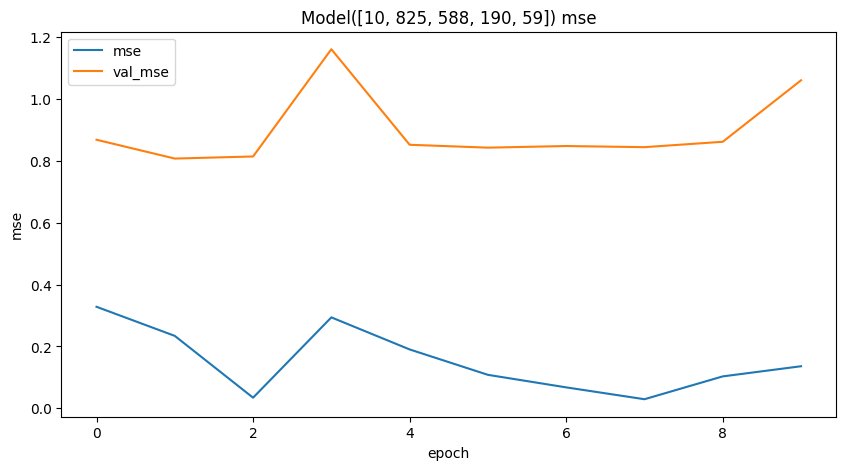

In [16]:
# def create_model_prod(X_train, y_train, window_size):
#     model = Sequential()
#     model.add(LSTM(128,  return_sequences=True, input_shape=(window_size, X_train.shape[1])))
#     model.add(Dropout(0.2))
#     model.add(LSTM(32))         
#     model.add(Dropout(0.2))
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(y_train.shape[1], activation='linear'))
#     #model.add(Dense(y_train.shape[1], activation='softmax'))
#     model.compile(optimizer='adam', loss='mae', metrics=['mse'])
#     return model  
plot_figsize=(10,5)
def create_model(X_train, y_train, window_size, lstm1_units, lstm2_units, dense1_units, dense2_units):
    # 1200, 132, 44
    # 800, 800, 64
    model = Sequential()
    input_shape=(window_size, X_train.shape[1])
    print(f"Creating model({window_size, lstm1_units, lstm2_units, dense1_units, dense2_units}), input shape={input_shape}")
    
    model.add(LSTM(lstm1_units,  return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(lstm2_units))         
    model.add(Dropout(0.2))
    model.add(Dense(dense1_units, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(dense2_units, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='linear')) # linear for regression
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model


def plot_history(model_name, history, metric=None):
    """ Plot history loss and metrics"""
    metric_names = [metric] if metric else history.history
    
    # Print all merrics
    for metric_name in metric_names:
        # Validation metrics names will be calculated from related train metrics
        if metric_name.startswith("val_"): continue

        # Plot metric and related test (val_..) metric
        plt.figure(figsize=plot_figsize)
        names=[metric_name, f"val_{metric_name}"]
        for name in names:
            plt.plot(history.history[name])
        # Captions and show the plot
        plt.title(f"{model_name} {metric_name}")
        plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(names, loc='upper left')
        plt.show()

def fit_model(model, train_gen, test_gen):
    # Fit the model
    epochs=10
    steps_per_epoch=5
    history=model.fit(train_gen, validation_data=test_gen, epochs=epochs, steps_per_epoch=steps_per_epoch)
    return history


def evaluate_models(*specs):
    results={}
    for unit_spec in specs:
        window_size=unit_spec[0]
        model = create_model(X_train, y_train, window_size, unit_spec[1], unit_spec[2], unit_spec[3], unit_spec[4])
        
        train_gen = TimeseriesGenerator(X_train, y_train, length=window_size)
        test_gen = TimeseriesGenerator(X_test, y_test, length=window_size)        
        history = fit_model(model, train_gen, test_gen)
        
        model_name = f"Model({unit_spec})"
        results[model_name] = history
    for model_name in results:
        plot_history(model_name, results[model_name], "mse")

    
# Good: 80, 512, 20
evaluate_models([10,825,588,190,59])
